### 시도해볼 만한 것
1. Convolution filter
2. 채널 개수
3. activation
4. 모델 구조
5. BatchNorm 사용 유무
6. Dropout 사용 유무, 비율 변경

# 라이브러리 import

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 50

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# ModelCheckpoint
mc = ModelCheckpoint(filepath='./model.h5',
                     monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1,
                    )

print(ROOT_PATH)

/home/aiffel0042/aiffel


# 데이터 준비
---
- 총 5,856개의 X-Ray 이미지, 2개의 범주 (폐렴/정상)
- 3개의 하위 데릭토리 (train, test, val)
    - train : 5216개
    - test : 624개
    - validation : 16개
- validation이 부족하여서 train에서 더 가져온다
    - train : 4185개
    - test : 624개
    - validation : 1047개

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
train_filenames[0]

'/home/aiffel0042/aiffel/chest_xray/train/NORMAL/IM-0221-0001.jpeg'

In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
filenames[0]

'/home/aiffel0042/aiffel/chest_xray/train/NORMAL/IM-0221-0001.jpeg'

#### 데이터의 클래스 불균형(imbalance)
- 정상보다 폐렴 이미지수가 3배가 더 많기 때문에 학습이 잘 진행되지 않을 것이다.
    - CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘한다.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1081
Pneumonia images count in training set: 3104


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


#### 클래스 라벨 확인

In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


#### dataset을 만들 함수 선언
- ```get_label```
    - 파일의 경로로부터 문자열 처리를 통해서 label 추출
- ```decode_img```
    - 이미지파일을 tensor로 변환 후, resize
- ```process_path```
    - 위에서 선언한 ```get_label```로 경로를 가져온다
    - ```tf.io.read_file```을 이용해서 경로로부터 이미지를 읽는다
    - 위에서 선언한 ```get_label```로 tensor로 전환, 이미지 resize

In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [12]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### 데이터셋 만들기
- map을 활용해서 ```process_path```함수를 적용

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 파이프라인 완성시키기
- 위에서 만들어 놓은 ```train_ds```, ```test_ds```를 완성시킨다.
- ```augment```함수
    - augmentation을 적용할 때는 좌우 반전만 적용한다.
    - 의료영상의 경우, 일반적인 이미지처리에서 사용하는 augmentation들은 성능 향상에 도움이 된다고 말할 수 없다.
    - X-RAY와 같은 의료영상의 특성상 오히려 noise가 되어서 방해를 할 수도 있기 때문
    - 이러한 점에서 오히려 **GAN**을 통해서 새로운 의료영상을 생성해내고 이렇게 생성한 데이터는 개인정보 노출에 대한 위험도 없다고 한다.
- ```prepare_for_training``` 함수
    - augmentation을 수행할지 안할지 bool형 변수 ```aug```를 받고 입력되는 데이터셋에 다음과 같은 작업을 수행한다.
        1. augment함수 적용 여부
        2. suffle
        3. reapeat
        4. batch
        5. prefetch

In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000, aug=False):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    if aug :
        ds = ds.map(
                augment,       # augment 함수 적용
                num_parallel_calls=2
            )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

flag = True
train_ds = prepare_for_training(train_ds, aug=flag)
val_ds = prepare_for_training(val_ds, aug=flag)

### 완성한 파이프라인을 거친 데이터 시각화

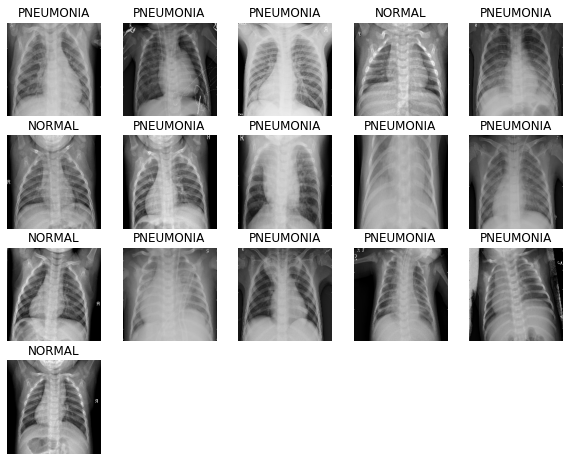

In [17]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# 모델 만들기
---
1. conv block 생성
2. dense block 생성
3. 전체 모델 생성


### SeparableConv2D??
---
- Depthwise Separable Convolution : 깊이별 분리 합성곱
- 입력 채널별로 따로따로 공간의 합성곱을 수행 (```SeparableConv2D```)
- 공간 특성과 채널 방향 특성을 독립적으로 인식하여 학습하고, 모델 파라미터와 연산수를 줄인다 = 더 빠르고 효율적인 학습
- **제한된 데이터로 작은 모델을 처음부터 훈련시킬 때 특히 더 중요**

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D()
    ]
    )
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.SeparableConv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        
        conv_block(64),
        conv_block(64),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.summary()
    
    return model

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 180, 180, 16)      91        
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 180, 180, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 64)        9728      
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)       

## 모델 학습

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, mc]
    )

Epoch 1/50
261/261 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.7586 - precision: 0.9092 - recall: 0.7495
Epoch 00001: val_accuracy improved from -inf to 0.30481, saving model to ./model.h5
261/261 [==============================] - 32s 123ms/step - loss: 0.5013 - accuracy: 0.7586 - precision: 0.9092 - recall: 0.7495 - val_loss: 0.9398 - val_accuracy: 0.3048 - val_precision: 0.7576 - val_recall: 0.0969
Epoch 2/50
261/261 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8762 - precision: 0.9674 - recall: 0.8623
Epoch 00002: val_accuracy did not improve from 0.30481
261/261 [==============================] - 32s 123ms/step - loss: 0.2931 - accuracy: 0.8762 - precision: 0.9674 - recall: 0.8623 - val_loss: 6.6445 - val_accuracy: 0.2894 - val_precision: 1.0000 - val_recall: 0.0440
Epoch 3/50
261/261 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.8920 - precision: 0.9671 - recall: 0.8843
Epoch 00003: val_accuracy did 

## 학습 결과 시각화

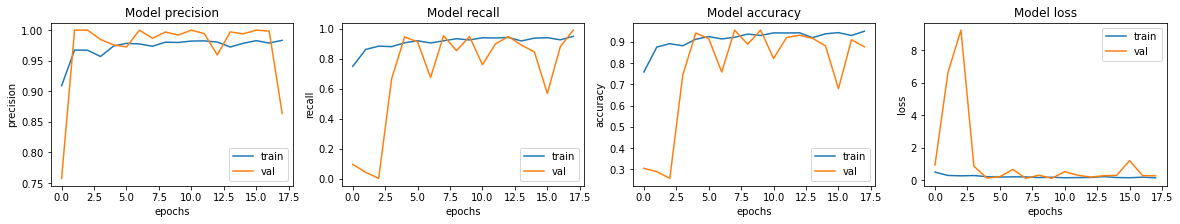

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 모델 평가

In [26]:
new_model = tf.keras.models.load_model('./model.h5')

In [27]:
loss, acc, prec, rec = new_model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 0.5644 - accuracy: 0.8526 - precision: 0.8143 - recall: 0.9897


# 정리
---
1. 학습 결과 시각화 부분을 보면 Accuracy는 상승하고 Loss는 가끔 튀는 부분이 있지만 0에 수렴하는 모습을 볼 수 있다.
2. 성능향상을 위한 시도
    - Augmentation을 수행했을 때, 기존에 Augmentation을 적용하지 않았을 때보다 Accuracy가 10정도 줄어드는 것을 확인할 수 있었다.
    - 다음과 같은 방식으로 Accuracy를 **85**까지 올릴 수 있었다.
        - input층 이후이 있던 일반 Conv2D layer를 Separable Conv2D layer로 변경하였다.
        - 기존에 conv_block(32), conv_block(64), conv_block(128), <u>Dropout(0.2)</u>, conv_block(256), <u>Dropout(0.2)</u>
            - conv_block(32), conv_block(64), **conv_block(64)**, <u>Dropout(0.2)</u>, conv_block(128), <u>Dropout(0.2)</u>, **BatchNorm()**, conv_block(256), <u>Dropout(0.2)</u>, **BatchNorm()**
        - conv_block(64)를 하나 추가하였고 뒷단에 BatchNorm층을 추가해주었다.
3. 개선점
    - 기존의 augmentation을 수행했을 때 왜 정확도가 더 낮아질까 생각을 해보았다.
    - 원래 데이터는 정상 사진과 폐렴 사진에 대한 데이터 비가 1:3으로 정상 데이터가 많이 부족했다.
    - 하지만 이상태에서 Augmentation을 수행하게 될 경우 imbalance는 더 심해질 것으로 생각했고 그래서 정확도가 더 낮게 나온 것이 아닐까 생각을 했다.
    - 하지만 여기서 수행한 Augmentation은 이후에 class weight로 조정을 해주었지만 다른 방법으로 생각해 본것은 처음에 데이터셋을 train, valid 데이터셋을 만들기 전에 train데이터에 대해서만 좌우반전 Augmentation을 수행한다면 imbalance가 줄어들 것이고 그 상태로 train, valid로 나눠주는 것이 좋지 않을까 생각을 해보았다.